### Simple BB84 Implementation in Netsquid for 2 nodes
#### This implementation uses the BB84 Protocol for Quantum Key Distribution in a 2-node Quantum Network . It creates a single Quantum Channel (unidirectional) and two Classsical Channels (bidirectional) with the respective Callback Functions.
_ref: https://github.com/h-oll/netsquid-private/blob/master/BB84/BB84.py (adapted by D-Cryp7 for Netsquid 1.1.6)_

In [1]:
# imports
import numpy as np
import netsquid as ns
from netsquid.nodes.node import Node
from netsquid.nodes.connections import DirectConnection
from netsquid.components import ClassicalChannel, QuantumChannel,FibreLossModel
from netsquid.qubits import create_qubits
from netsquid.qubits.operators import *
from random import seed , randint
from netsquid.protocols import Protocol
from netsquid.components.models import FixedDelayModel, GaussianDelayModel, FibreDelayModel

In [2]:
# Measures randomly in the Standard or Hadamard basis
def random_ZX_measure(num_bits, qlist):
    seed(randint(0, 2 ** num_bits))
    opList = [2] * num_bits
    loc_res_measure = [2] * num_bits
    for q in qlist:
        rbit = randint(0, 1)
        a = int(q.name[1:])
        opList[a] = rbit
        if rbit == 0:
            loc_res_measure[a] = ns.qubits.qubitapi.measure(q, observable = Z) #measure in standard basis
        elif rbit == 1:
            loc_res_measure[a] = ns.qubits.qubitapi.measure(q, observable = X) #measure in Hadamard basis
        else:
            print("measuring ERROR!!\n")
    return opList,loc_res_measure

In [3]:
# Create random qubits - Starting the BB84 Protocol
def create_random_qubits(num_bits, v):
    seed(randint(0, 4 ** num_bits))
    res_state = []
    qlist = []
    qlist = create_qubits(num_bits, system_name = "Q") 
    for i in range(0, num_bits):
        res_state.append(randint(0,3))
    det = []
    '''
        a: Random Number between 0 and 3
           0: |0> state (default)
           1: |1> state (apply single-qubit Pauli-X gate to |0>)
           2: |+> state (apply Hadamard gate to |0>)
           3: |-> state (apply single-qubit Pauli-X gate and Hadamard gate to |0>)
    '''
    for a, b in zip(res_state, qlist):
        if a == 0:
            det.append("0")
            pass
        elif a == 1:
            ns.qubits.operate(b, ns.X)
            det.append("1")
        elif a == 2:
            ns.qubits.operate(b, ns.H)
            det.append("+")
        elif a == 3:
            ns.qubits.operate(b, ns.X)
            ns.qubits.operate(b, ns.H)
            det.append("-")
        else:
            print("Create random bits ERROR!!")
    if v: # for verbose
        print("Alice Random Qubits: ", det, str(len(det)) + " Qubits")
    return res_state, qlist

In [5]:
# Match measures between Alice and Bob
def Compare_measurement(num_bits, stateList, opList):
    matchList = []
    for i in range(0, num_bits):
        if stateList[i] < 2 and opList[i] == 0:    #measure in standard basis
            matchList.append(i)
        elif stateList[i] >= 2 and opList[i] == 1: #measure in Hadamard basis
            matchList.append(i)
        else:
            pass
    return matchList

In [6]:
class BB84(Protocol):
    
    # BB84 Functions
    
    # Step 1: Alice send random qubits to Bob
    def BB84_Alice_sendQubits(self):
        self.stateList,qlist = create_random_qubits(self.num_bits, self.v)
        self.node_A.ports["portQA"].tx_output(qlist)
    # Step 2 & 3: Bob measure randomly and send the list of measures to Alice
    def BB84_Bob_measure_send(self, qlist): # some qubits might be lost
        qlist = qlist.items
        if isinstance(qlist[0], int):
            pass
        else:
            # B measuring
            B_basis, self.res_measure = random_ZX_measure(self.num_bits, qlist)
            det = []
            for el in B_basis:
                if el == 0:
                    det.append('0')
                else:
                    det.append('+')
            if B_basis == -1:
                print("B measuring failed!!")
            else :
                # B send measurement
                if self.v: # for verbose
                    print("Bob get: ", qlist)
                    print("Bob measure: ", det)
                self.portCB.tx_output(B_basis)  
    # Step 4 & 5: Alice generates a match list and send it to Bob 
    def BB84_Alice_measure_send_keygen(self, opList):
        opList = opList.items
        # A measure 
        matchList = Compare_measurement(self.num_bits, self.stateList, opList) #get opList from B
        
        # A return  matchList to B
        self.portCA.tx_output(matchList)
        
        for i in matchList:
            self.key_A.append(self.stateList[i] % 2) #quantum state 0,+:0    1,-:1
        if self.v:
            print("Alice get: ", opList)
            print("Match List: ", matchList)
            print("Alice Shared Key: ",self.key_A)
        return self.key_A
    # Step 6: Bob recieves the match list and generates the key - Protocol completed
    def BB84_Bob_keygen(self, matchList):
        matchList = matchList.items

        for i in matchList:
            self.key_B.append(self.res_measure[int(i)][0])
        if self.v:
            print("Bob Shared Key: ",self.key_B)
        return self.key_B
    
    # Initialization of the Quantum Network
    def __init__(self, num_bits = 8, fibre_len = 10**-6, fibre_loss_init = 0.2, fibre_loss_length = 0.25, 
                 v = False):
        super().__init__()
        self.node_A = Node("A",ID = 0, port_names=["portQA","portCA"])
        self.node_B = Node("B",ID = 1, port_names=["portQB","portCB"])
        self.portCB = self.node_B.ports["portCB"] #classical ports are not inherited by nodes
        self.portCA = self.node_A.ports["portCA"]
        self.MyQfiber = None
        self.MyCfiber = None
        self.num_bits = num_bits
        self.stateList = None
        self.res_measure = None
        self.key_A = []
        self.key_B = []
        self.fiberLenth = fibre_len
        self.fibre_loss_init = fibre_loss_init
        self.fibre_loss_length = fibre_loss_length
        self.v = v
        self.start()
        
    def stop(self):
        super().stop()
        self._running = False
        
    def is_connected():
        super().is_connected()
        pass
    
    # Start the BB84 Protocol
    def start(self):
        super().start()

        # print("starting BB84 protocol")
        
        # Create Quantum Channel (Optical Fiber)
        self.MyQfiber = QuantumChannel("QFibre_A->B", length = self.fiberLenth, 
            loss_model = FibreLossModel(p_loss_length = self.fibre_loss_length,
                                        p_loss_init = self.fibre_loss_init), 
            depolar_rate = 0, noise_model = "default") 

        # Create Classical Channel (Optical Fiber)
        self.MyCfiber = DirectConnection("CFibreConn_A->B",
            ClassicalChannel("CFibre_A->B", length = self.fiberLenth),
            ClassicalChannel("CFibre_B->A", length = self.fiberLenth))
        
        self.node_A.connect_to(self.node_B, self.MyQfiber,
            local_port_name="portQA", remote_port_name="portQB")
        
        self.node_B.connect_to(self.node_A, self.MyCfiber,
            local_port_name="portCB", remote_port_name="portCA")
        
        # Set Callback Functions
        self.node_B.ports["portQB"].bind_input_handler(self.BB84_Bob_measure_send)
        self.node_A.ports["portCA"].bind_input_handler(self.BB84_Alice_measure_send_keygen)
        self.node_B.ports["portCB"].bind_input_handler(self.BB84_Bob_keygen)
        
        # Alice Starts
        self.BB84_Alice_sendQubits()

In [18]:
import time # for benchmarks

def run_BB84_sim(runtimes = 1, num_bits = 8, fibre_len = 10**-6, fibre_loss_init = 0.2,fibre_loss_length = 0.25, verbose = False):
    ns.sim_reset()
    
    run_times = runtimes
    MyBB84List = []  # Resulted keys in the QKD
    
    for i in range(run_times): 
        MyBB84List.append(BB84(num_bits,fibre_len,fibre_loss_init,fibre_loss_length, verbose).key_B)
        
    ns.sim_run()
    
    return MyBB84List

In [21]:
# 10 independent BB84 Protocol simulations
run_BB84_sim(10, 8, 10**-18, 0.2, 0.25, False)

[[0, 1, 0],
 [0, 1, 1, 1],
 [0, 0, 0, 1],
 [1, 0],
 [1, 1, 1, 1],
 [0, 1, 0],
 [0, 1, 0, 0, 1],
 [1, 1],
 [1, 0, 0, 1],
 [1, 0, 0, 0]]

#### Symmetric Encryption
With the key exchanged, we can encrypt messages with AES for example.

In [25]:
from hashlib import sha256
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

k = run_BB84_sim(1, 256, 10**-18)[0]
strk = ''.join([str(i) for i in k])
key = bytes(int(strk[i : i + 8], 2) for i in range(0, len(strk), 8))
key_hash = sha256(key).digest()
cipher = AES.new(key_hash, AES.MODE_ECB)
m = b"S3CR3T_M3SS4G3!!"
c = cipher.encrypt(pad(m, 16))
c.hex()

'b11d6dadb498f11aea1684bdb9411a869c0cbf2803938bb37874440107e8856f'

#### Interesting plots
The reference also makes some plots using the following function

In [26]:
import matplotlib.pyplot as plt

def BB84_plot():
    y_axis=[]
    x_axis=[]
    run_times=25
    num_bits=256
    min_dis=1000
    max_dis=10000

    #first curve
    for i in range(min_dis,max_dis,1000):
        key_sum=0.0
        x_axis.append(1.*i/1000) 
        key_list=run_BB84_sim(run_times,num_bits,1.*i/1000) #given runtimes, numberof bits and distance, use default loss model
        for j in key_list:
            key_sum=key_sum+len(j)
        y_axis.append(key_sum/run_times/num_bits)
        
    plt.plot(x_axis, y_axis, 'go-',label='FibreLossModel1')
    plt.plot(x_axis, [np.mean(y_axis)]*len(y_axis), linestyle='--', label = "Mean1")
    
    y_axis.clear() 
    x_axis.clear()
    
    #second curve
    for i in range(min_dis,max_dis,1000):
        key_sum=0.0
        x_axis.append(1.*i/1000) 
        key_list=run_BB84_sim(run_times,num_bits,1.*i/1000  #given runtimes, numberof bits, distance and loss model configuration
            ,fibre_loss_init=0.83,fibre_loss_length=0.2)
        for j in key_list:
            key_sum=key_sum+len(j)
        y_axis.append(key_sum/run_times/num_bits)

    plt.plot(x_axis, y_axis, 'bo-',label='FibreLossModel2')
    plt.plot(x_axis, [np.mean(y_axis)]*len(y_axis), linestyle='--', label = "Mean2")
        
        
    plt.ylabel('average key length/original qubits length')
    plt.xlabel('fibre length (km)')

    
    #plt.xscale('log')
    plt.legend()
    plt.savefig('plot.png')
    plt.show()

Basically, it runs the BB84 Protocol many times with different fibre loss models. The only thing that is interesting is that if we want to generate a 256 bits key for example, the relation between the resulting key length and the actual key size that the user wants is 50% due to the Bob errors in random measures. It will be more interesting if the insert some noise and play more with the optical fiber model, in addition to introduce the Quantum Memory and Quantum Processor, which have functions in Netsquid.

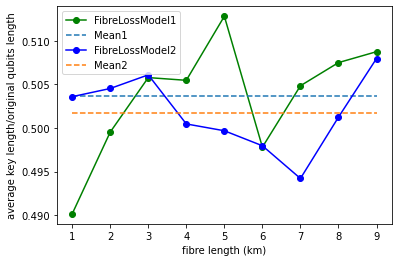

CPU times: user 23.6 s, sys: 495 ms, total: 24.1 s
Wall time: 25.5 s


In [27]:
%%time 
BB84_plot()